## (1) Monte Carlo Simulation

The COVID scare was a wake-up call, highlighting the vulnerability of our hyper-connected modern world to the threat of pandemics. Now that the COVID urgency has passed, governments across the globe are rushing to update their emergency action plans and disaster scripts.

As part of this effort, you’ve been hired by a medical team that has been tasked with developing fast procedures to detect a blood-borne virus. 

Since these tests need to be administered to large groups in the population, and testing resources are limited, the medics have come up with the following procedure: 

1. They started from the assumption that they need to test $N$ blood samples (of as many different individuals) and that $N$ is large (e.g., $N = 10^6$). 
2. Furthermore, the probability that an individual is infected is $p$, where $p$ is relatively small, e.g., $p < 0.1$.

Based on these assumptions they propose the following procedure to minimise the number of tests they have to run: Rather than testing each sample individually, take a batch of $k$ samples and mix them. Then this mixed sample is tested for the presence of the viral antigen:

- If the mixed sample tests **negative** (i.e., no viral antigen is detected), then all the individual samples were clear, and you therefore have the result for all $k$ individual samples that went into the batch.
- If the mixed sample tests **positive** (i.e., the viral antigen is present indicating infection), one needs to retest all individual samples that went into the batch, in order to find out which individual(s) are actually infected.

**Questions**
1. Use Monte Carlo simulation to estimate the optimal batch size $k$ (i.e., the one that minimises the expected number of tests) for a given value of $p$ where $p$ can take values between $10^{-1}$ and $10^{-4}$.
2. In order to convince your superiors that this a good investment, quantify the **expected reduction in workload** (compared to testing all samples individually).

### Class and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Monte_Carlo:
    def __init__(self, 
                 probability, 
                 batch_size, 
                 sample_size = 1000000):
        self.p = probability
        self.k = batch_size
        self.N = sample_size
    
    # Calculate X
    def generate_sample(self):
        # Generate and return a random sample
        return np.random.choice(
            a=[1, 0], # positive / negative
            size=self.N, 
            p=[self.p, 1-self.p])
    
    # Calculate Expected Number of Tests
    def calculate_n_tests(self):
        # Getting the random sample
        X = self.generate_sample()

        # Counter for Number of Tests
        n_tests = 0

        # Splitting the sample into batches and counting tests
        for i in range(0, len(X), self.k):
            batch = X[i:i + self.k]
            # Testing the batch
            n_tests += 1
            # If any positive, test everyone individually
            if any(individual == 1 for individual in batch):  # If any positive, test each individually
                n_tests += len(batch)
    
        return n_tests
    
    # Calculating the Expected Probability and SD of Finding a Positive in a Given Batch
    def probability_positive_in_batch(self):
        # Getting the random sample
        X = self.generate_sample()
        
        # List for Storing the Results
        all_results = []

        # Dividing the samples
        samples = [X[i:i + self.k] for i in range(0, len(X), self.k)]

        # Testing all Samples
        all_results = [any(individual == 1 for individual in batch) for batch in samples]

        # Getting the Expected Probability and SD
        MC_mean = np.mean(all_results)
        MC_mean_sd = np.std(all_results) / np.sqrt(self.N)

        return {"e_mean": MC_mean, "e_mean_sd": MC_mean_sd}


In [3]:
def simulate_monte_carlo(probabilities, k_values, sample_size=100000):
    # Initialize an empty DataFrame
    results_df = pd.DataFrame(index=k_values, columns=probabilities)

    # Iterating over the different Batch Sizes
    for k in k_values:
        # Iterating over the different Probabilities
        for p in probabilities:
            monte_carlo = Monte_Carlo(probability=p, batch_size=k, sample_size=sample_size)
            n_tests = monte_carlo.calculate_n_tests()
            results_df.loc[k, p] = n_tests

    return results_df

In [4]:
def find_optimal_batch_size(df):
    optimal_batches = {}

    for p in df.columns:
        optimal_k = df[p].idxmin()
        optimal_batches[p] = optimal_k

    return optimal_batches

In [56]:
def plot_MC_sim(df):
    # Define color mapping
    distinct_colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 20 distinct colors
    # More gradual colors for k > 20
    gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(df.index) - 20))
    
    # Combine color lists
    colors = np.vstack((distinct_colors, gradual_colors))

    plt.figure(figsize=(14, 8))
    
    # Plot each batch size with its color
    for i, k in enumerate(df.index):
        if k <= 20 or k % 10 == 0:
            label = f'Batch Size: {k}'
        else:
            label = None  # Only label specific lines
        plt.plot(df.columns, df.loc[k], color=colors[i], label=label)

    # Add a dashed horizontal line at y = 1000000
    plt.axhline(y=1000000, color='red', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()


In [40]:
import plotly.graph_objs as go
from plotly.offline import plot
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot

def plot_interactive_monte_carlo(results_df, title='Number of Tests by Batch Size and Probability', horizontal_line_y=1000000):
    # Assuming you are working in a Jupyter notebook environment
    # init_notebook_mode(connected=True)  # Uncomment this if in Jupyter

    # Create an empty list to hold all the plot traces
    traces = []

    # Define color mapping
    distinct_colors = plt.cm.tab20(np.linspace(0, 1, 5))  # distinct colors
    gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(results_df.index) - 5))
    colors = np.vstack((distinct_colors, gradual_colors))

    # Convert the colors to hex format for Plotly
    colors_hex = ['rgb({}, {}, {})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

    # Add a trace for each batch size
    for i, k in enumerate(results_df.index):
        traces.append(go.Scatter(
            x=results_df.columns,
            y=results_df.loc[k],
            mode='lines',
            name=f'Batch Size: {k}',
            line=dict(color=colors_hex[i])
        ))

    # Define the layout of the plot
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Probability'),
        yaxis=dict(title='Number of Tests', range=[0, results_df.values.max() + results_df.values.max() * 0.1]),
        hovermode='closest'
    )

    # Define the figure
    fig = go.Figure(data=traces, layout=layout)

    # Add a horizontal line at y = horizontal_line_y
    fig.add_shape(
        type='line',
        x0=results_df.columns.min(),
        y0=horizontal_line_y,
        x1=results_df.columns.max(),
        y1=horizontal_line_y,
        line=dict(dash='dash', color='grey', width=1)
    )

    # Show the figure
    # fig.show()  # Use iplot(fig) if within Jupyter Notebook, fig.show() if not
    return(fig)

### Sim 1: P: 0.0001 - 0.1000 (0.005), k: 2 - 100

In [41]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.1000
step =  0.0050
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,100)

# Simulation
sim_1 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

KeyboardInterrupt: 

In [42]:
# Saving the dataframe
# sim_1.to_csv('../MAS - Individual Assignment/sim_1.csv', index=True)
sim_1 = pd.read_csv('sim_1.csv', index_col=0)

In [43]:
# Optimal Batch Size
sim_1_optimals = find_optimal_batch_size(sim_1)
print(sim_1_optimals)

{'0.0001': 76, '0.0051': 15, '0.0101': 10, '0.015099999999999999': 8, '0.0201': 8, '0.0251': 7, '0.0301': 6, '0.035100000000000006': 6, '0.040100000000000004': 6, '0.0451': 5, '0.050100000000000006': 5, '0.0551': 5, '0.0601': 5, '0.0651': 4, '0.07010000000000001': 4, '0.0751': 4, '0.0801': 4, '0.08510000000000001': 4, '0.0901': 4, '0.0951': 4, '0.10010000000000001': 4}


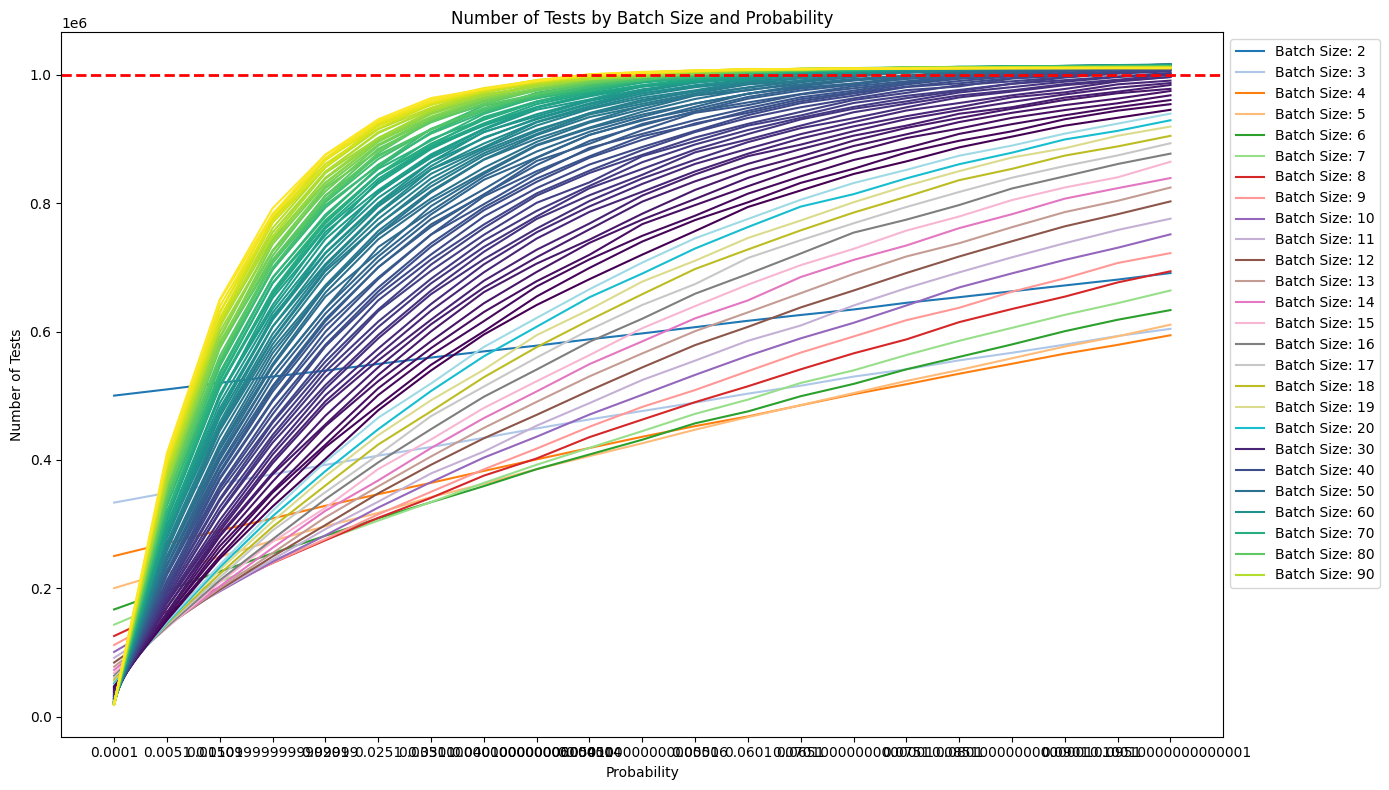

In [55]:
# Plotting
plot_MC_sim(sim_1)

In [39]:
sim_1_plotly = plot_interactive_monte_carlo(sim_1)
iplot(sim_1_plotly)

In [ ]:
plot(sim_1_plotly, filename='sim_1_plot.html')

'sim_1_plot.html'

### Sim 2: P: 0.0001 - 0.0050 (0.0001), k: 15 - 100

In [ ]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.0050
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(15,100)

# Simulation
sim_2 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [59]:
# Saving the dataframe
# sim_2.to_csv('../MAS - Individual Assignment/sim_2.csv', index=True)
sim_2 = pd.read_csv('sim_2.csv')

In [67]:
# Optimal Batch Size
sim_2_optimals = find_optimal_batch_size(sim_2)
print(sim_2_optimals)

{'0.0001': 94, '0.0002': 87, '0.00030000000000000003': 75, '0.0004': 51, '0.0005': 43, '0.0006000000000000001': 47, '0.0007000000000000001': 41, '0.0008': 42, '0.0009000000000000001': 38, '0.001': 39, '0.0011': 40, '0.0012000000000000001': 33, '0.0013000000000000002': 31, '0.0014000000000000002': 27, '0.0015': 27, '0.0016': 23, '0.0017000000000000001': 22, '0.0018000000000000002': 24, '0.0019000000000000002': 25, '0.002': 24, '0.0021': 20, '0.0022': 21, '0.0023': 23, '0.0024': 21, '0.0025': 22, '0.0026': 23, '0.0027': 17, '0.0028': 18, '0.0029': 20, '0.003': 21, '0.0031': 18, '0.0032': 19, '0.0033': 18, '0.0034': 18, '0.0035': 17, '0.0036': 16, '0.0037': 17, '0.0038': 15, '0.0039': 15, '0.004': 16, '0.0041': 17, '0.004200000000000001': 15, '0.004300000000000001': 15, '0.0044': 15, '0.0045000000000000005': 15, '0.004600000000000001': 15, '0.0047': 17, '0.0048000000000000004': 15, '0.004900000000000001': 15, '0.005': 16}


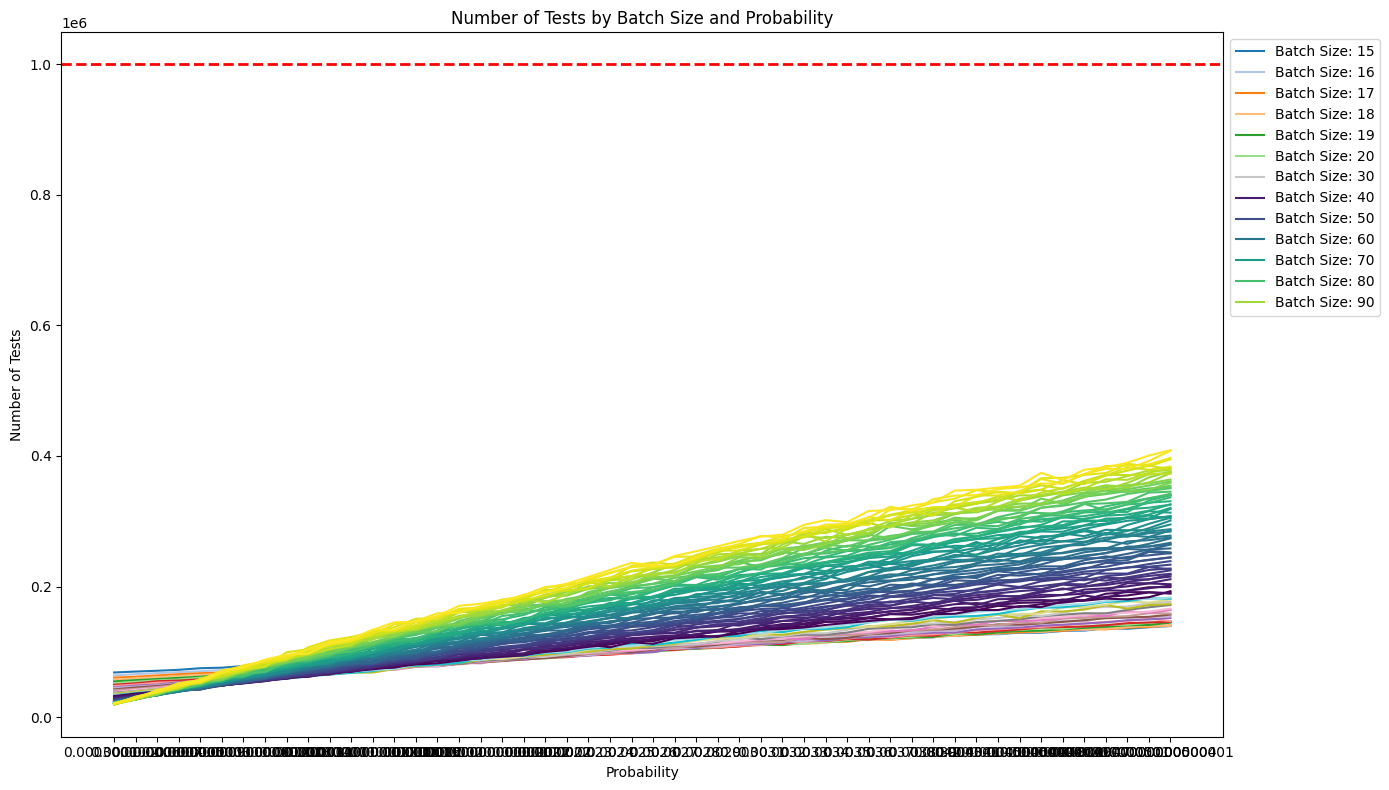

In [60]:
# Plotting
plot_MC_sim(sim_2)

In [30]:
sim_2_plotly = plot_interactive_monte_carlo(sim_2)
sim_2_plotly)

NameError: name 'sim_2' is not defined

In [ ]:
plot(sim_2_plotly, filename='sim_2_plot.html')

NameError: name 'sim_2_plotly' is not defined

### Sim 3: P: 0.005 - 0.10 (0.0001), k: 2 - 20

In [ ]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0100
end =   0.1000
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,20)

# Simulation
sim_3 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [ ]:
# Saving the dataframe
sim_3.to_csv('../MAS - Individual Assignment/sim_3.csv', index=True)

In [ ]:
# Optimal Batch Size
sim_3_optimals = find_optimal_batch_size(sim_3)
print(sim_3_optimals)

{0.01: 10, 0.0101: 10, 0.010199999999999999: 11, 0.010299999999999998: 10, 0.010399999999999998: 11, 0.010499999999999997: 11, 0.010599999999999997: 10, 0.010699999999999996: 10, 0.010799999999999995: 11, 0.010899999999999995: 11, 0.010999999999999994: 10, 0.011099999999999994: 10, 0.011199999999999993: 11, 0.011299999999999992: 10, 0.011399999999999992: 10, 0.011499999999999991: 10, 0.01159999999999999: 10, 0.01169999999999999: 9, 0.01179999999999999: 10, 0.011899999999999989: 11, 0.011999999999999988: 9, 0.012099999999999988: 10, 0.012199999999999987: 9, 0.012299999999999986: 9, 0.012399999999999986: 9, 0.012499999999999985: 9, 0.012599999999999984: 9, 0.012699999999999984: 9, 0.012799999999999983: 9, 0.012899999999999983: 9, 0.012999999999999982: 10, 0.013099999999999981: 9, 0.01319999999999998: 10, 0.01329999999999998: 10, 0.01339999999999998: 10, 0.013499999999999979: 10, 0.013599999999999978: 9, 0.013699999999999978: 9, 0.013799999999999977: 9, 0.013899999999999977: 9, 0.01399999

In [ ]:
sim_3_plotly = plot_interactive_monte_carlo(sim_3)
iplot(sim_3_plotly)

NameError: name 'sim_3' is not defined

In [ ]:
from plotly.offline import plot
plot(sim_3_plotly, filename='sim_3_plot.html')

'sim_3_plot.html'

In [ ]:
sim_3.mean(axis=1)

NameError: name 'sim_3' is not defined

### Sim 4

In [ ]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.1000
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(3,8)

# Simulation
sim_4 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [ ]:
sim_4.mean(axis=1)

3    473728.885
4    431131.236
5     419246.63
6    421623.016
7    431225.173
dtype: object

In [ ]:
sim_4_plotly = plot_interactive_monte_carlo(sim_4)
sim_4_plotly

In [ ]:
plot(sim_4_plotly, filename='sim_4_plotly.html')

'sim_4_plotly.html'

### Probabilitiy of Positive